# Load data from Kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd drive/MyDrive/CSE244/project/

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c ucsc-cse-244-fall-2023-final-project

In [ ]:
###Unzip files
import zipfile

zip_path = 'ucsc-cse-244-fall-2023-final-project.zip'

extraction_path = 'dataset/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [3]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import RandomCrop, RandomFlip, RandomTranslation, RandomRotation, RandomZoom, RandomContrast, RandomBrightness, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import tensorflow as tf
import random
from tensorflow import keras
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load Downloaded data from Kaggle into Keras dataset




In [4]:
class_lst = []
for i in range(100):
  class_lst.append(str(i))

base_dir = './dataset/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [5]:
### Load and split into train and validation datasets
train_dataset, validation_dataset = image_dataset_from_directory(train_dir,
                                            labels = 'inferred',
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(224, 224),
                                            label_mode='categorical',
                                            class_names = class_lst,
                                            subset ='both',
                                            validation_split = 0.2,
                                            seed = 42)

Found 1079 files belonging to 100 classes.
Using 864 files for training.
Using 215 files for validation.


In [ ]:
### Load test images Dataset
test_images = []

for i in range(1036):
  path = "./dataset/test/" + str(i) + ".jpg"
  im = Image.open(path)
  test_images.append(im.resize((224,224)))

# Pre-process Data

In [6]:
## Use the preprocess function inbuilt with efficientnet_v2 to preprocess input images
preprocess = keras.applications.efficientnet_v2.preprocess_input

In [7]:
train_dataset = preprocess(train_dataset)
validation_dataset = preprocess(validation_dataset)

In [ ]:
### Convert test_images from list to a numpy array and normalize the images
for i in range(len(test_images)):
  test_images[i] = np.array(test_images[i])
test_images = np.array(test_images)
test_images = preprocess(test_images)

# Download Base Model and Unfreeze training layers

In [8]:
##Download EfficientNetV2B2 pretrained model with imagenet weights
base_model = keras.applications.EfficientNetV2B2(weights = 'imagenet', include_top = False, pooling = 'avg', input_shape=(224,224,3))

35839040/35839040 [==============================] - 0s 0us/step


In [9]:
print(f'Number of layers in the base model: {len(base_model.layers)}')
for layer in base_model.layers:
  layer.trainable = False

base_model.summary()

Number of layers in the base model: 350
Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 1

In [10]:
### Unfreeze the last two layers with parameters (Convolutional and Batch Normalization layer)
base_model.layers[-4].trainable = True
base_model.layers[-3].trainable = True

In [11]:
base_model.summary()

Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalizatio

# Add Data Augmentation and Full Connected Layers

In [12]:
### Add Data Augmentation layers to the model
data_augmentation = Input(shape = (224,224,3))
data_augmentation = RandomRotation(factor = 0.2)(data_augmentation)
data_augmentation = RandomFlip()(data_augmentation)
data_augmentation = RandomZoom(height_factor = 0.2)(data_augmentation)
data_augmentation = RandomCrop(height = 224, width = 224)(data_augmentation)
data_augmentation = RandomTranslation(height_factor = 0.2, width_factor = 0.2)(data_augmentation)
data_augmentation = RandomContrast(factor = 0.2)(data_augmentation)
data_augmentation = RandomBrightness(factor = 0.2)(data_augmentation)

In [13]:
### Add the base model at the end of the data augmentation layers
model_1 = keras.models.Model(inputs = data_augmentation, outputs = base_model(data_augmentation))
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b2 (Functio  (None, 1408)              8769374   
 nal)                                                            
                                                                 
Total params: 8769374 (33.45 MB)
Trainable params: 295680 (1.13 MB)
Non-trainable params: 8473694 (32.32 MB)
_________________________________________________________________


In [14]:
### Add Fully Connected Dense layers (MLP) along with dropout and batch normalization, and output softmax layer
model = model_1.output
model = Flatten()(model)
model = Dense(512, activation = 'relu')(model)
model = Dropout(0.4)(model)
model = BatchNormalization()(model)
model = Dense(256, activation = 'relu')(model)
model = Dropout(0.3)(model)
model = BatchNormalization()(model)
# model = Dense(256, activation = 'relu')(model)
# model = Dropout(0.3)(model)
# model = BatchNormalization()(model)
model = Dense(100, activation = 'softmax')(model)

In [15]:
model = keras.models.Model(inputs = model_1.input, outputs = model)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b2 (Functio  (None, 1408)              8769374   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 512)               721408    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                            

# Compile and Train Model

In [22]:
### Define Scheduler and compile the model
schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate = 0.00, warmup_target = 0.001, warmup_steps = 1000, decay_steps = 1000)
optimizer = keras.optimizers.AdamW(learning_rate = schedule)

model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [25]:
### Define callback functions and train the model
es_callback = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode = 'min', restore_best_weights = True)
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='./model_checkpoint/',
    monitor='val_loss',
    mode='max',
    save_best_only=True)

history = model.fit(train_dataset, epochs = 50, validation_data=validation_dataset, callbacks = [model_checkpoint_callback, es_callback], shuffle = True)

Epoch 1/50
27/27 [==============================] - 226s 8s/step - loss: 1.1575 - accuracy: 0.6481 - val_loss: 1.5325 - val_accuracy: 0.5163
Epoch 2/50
27/27 [==============================] - 112s 4s/step - loss: 1.1987 - accuracy: 0.6354 - val_loss: 1.4917 - val_accuracy: 0.5256
Epoch 3/50
27/27 [==============================] - 108s 4s/step - loss: 1.1742 - accuracy: 0.6609 - val_loss: 1.4513 - val_accuracy: 0.5349
Epoch 4/50
27/27 [==============================] - 124s 4s/step - loss: 1.0978 - accuracy: 0.6794 - val_loss: 1.4287 - val_accuracy: 0.5442
Epoch 5/50
27/27 [==============================] - 111s 4s/step - loss: 1.0864 - accuracy: 0.6840 - val_loss: 1.4117 - val_accuracy: 0.5488
Epoch 6/50
27/27 [==============================] - 102s 4s/step - loss: 1.0394 - accuracy: 0.6817 - val_loss: 1.4016 - val_accuracy: 0.5860
Epoch 7/50
27/27 [==============================] - 107s 4s/step - loss: 1.0253 - accuracy: 0.6921 - val_loss: 1.3844 - val_accuracy: 0.5860
Epoch 8/50
27

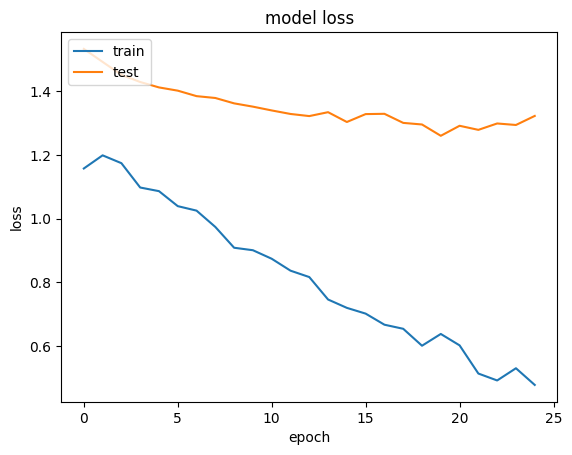

In [26]:
### Plot for training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

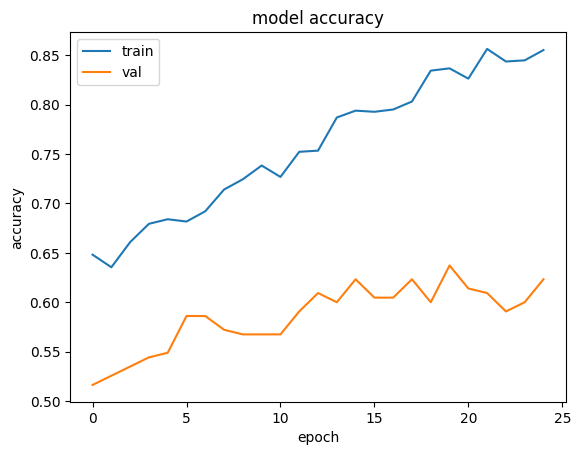

In [27]:
### Plot for training accuracy and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Load best trained model and Predict on Test Images


In [28]:
### Import the best trained model from the model checkpoint
new_model = tf.keras.models.load_model('./model_checkpoint')

In [29]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b2 (Functio  (None, 1408)              8769374   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 256)               360704    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                            

In [33]:
### Pass the images to the model for predictions
predictions = new_model.predict(test_images)

33/33 [==============================] - 93s 3s/step


In [34]:
### Predicted labels
predicted_labels = np.argmax(predictions, axis = 1)

In [35]:
pred_labels = []
for i, label in enumerate(predicted_labels):
  pred_labels.append((i,label))

In [37]:
### Add the predicted labels to a dictionary and then to a dataframe to convert it to csv
image_label = {'ID':[],'Label':[]}
for prediction in pred_labels:
  image_label['ID'].append(str(prediction[0]) + ".jpg")
  image_label['Label'].append(str(prediction[1]))

In [42]:
df = pd.DataFrame(data=image_label)
df = df.set_index('ID')
df.to_csv('/submission.csv')